In [ ]:
!pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
import librosa
audio_data = '/content/drive/MyDrive/dataset/capuchin/XC22397-5.wav'
x , sr = librosa.load(audio_data)
print(type(x), type(sr))
print(x.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(77175,) 22050


In [ ]:
librosa.load(audio_data, sr=44100)

(array([-0.02609134, -0.03809983, -0.03959198, ...,  0.0035299 ,
        -0.00197707,  0.00837703], dtype=float32), 44100)

In [ ]:
import IPython.display as ipd
ipd.Audio(audio_data)

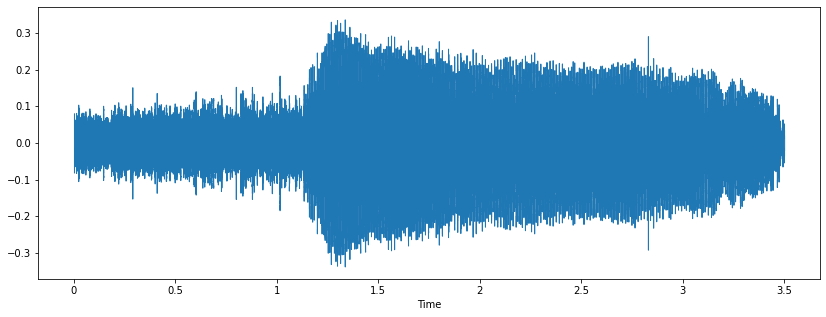

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)

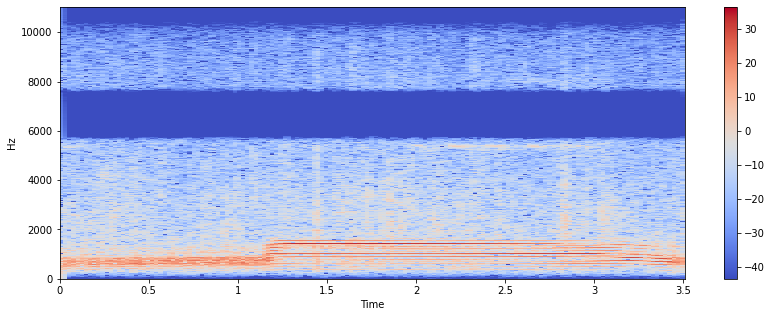

In [ ]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

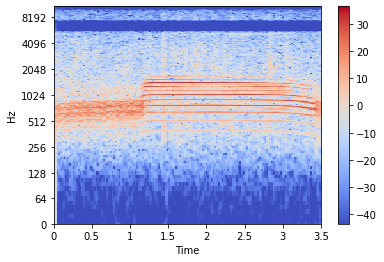

In [ ]:
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

In [ ]:
import soundfile 
sr = 22050 
T = 5.0    
t = np.linspace(0, T, int(T*sr), endpoint=False) 
x = 0.5*np.sin(2*np.pi*220*t)
ipd.Audio(x, rate=sr) 
soundfile.write('XC22397-5.wav', x, sr)

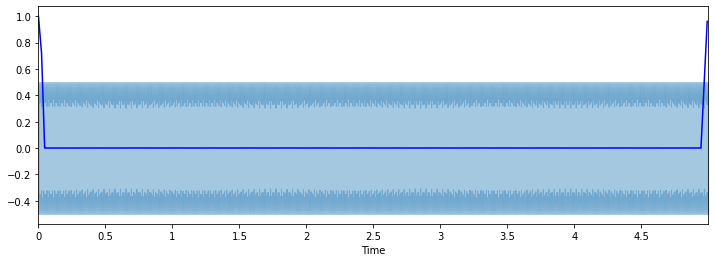

In [ ]:
import sklearn
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroids.shape
plt.figure(figsize=(12, 4))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='b')

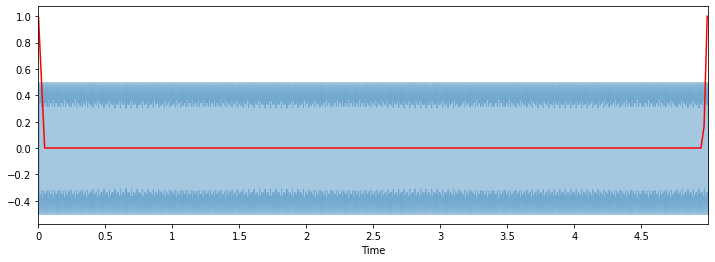

In [ ]:
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]
plt.figure(figsize=(12, 4))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

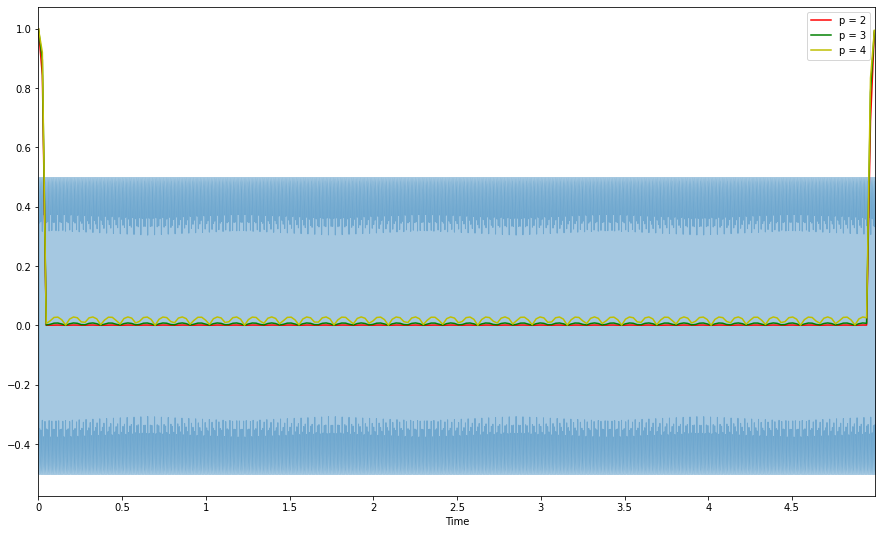

In [ ]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=4)[0]
plt.figure(figsize=(15, 9))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))

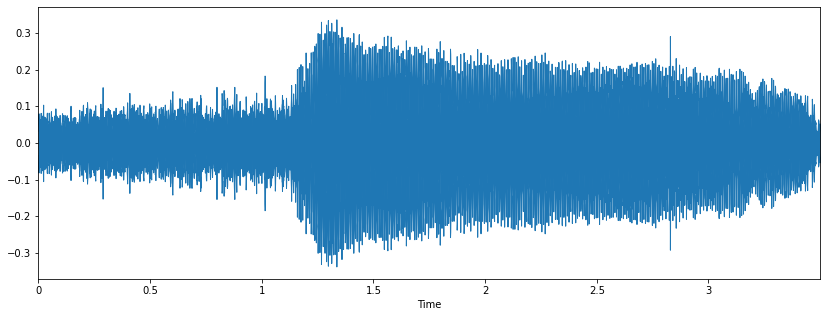

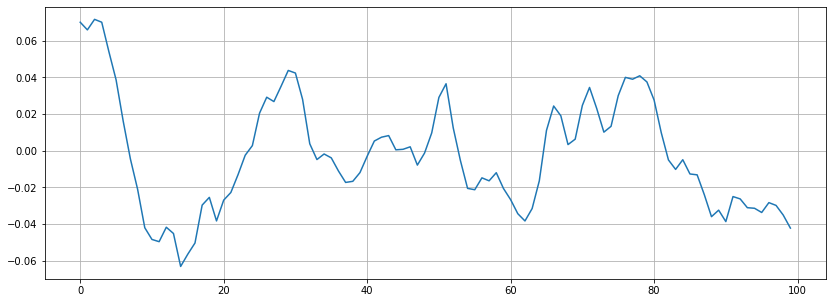

In [ ]:
x, sr = librosa.load(audio_data)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

In [ ]:
import cv2
import audioread
import logging
import os
import random
import time
import warnings

import librosa
import numpy as np
import pandas as pd
import soundfile as sf
import torch
import torch.nn as nn
import torch.cuda
import torch.nn.functional as F
import torch.utils.data as data

from contextlib import contextmanager
from pathlib import Path
from typing import Optional

from fastprogress import progress_bar
from sklearn.metrics import f1_score
from torchvision import models

In [ ]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
    
    
def get_logger(out_file=None):
    logger = logging.getLogger()
    formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
    logger.handlers = []
    logger.setLevel(logging.INFO)

    handler = logging.StreamHandler()
    handler.setFormatter(formatter)
    handler.setLevel(logging.INFO)
    logger.addHandler(handler)

    if out_file is not None:
        fh = logging.FileHandler(out_file)
        fh.setFormatter(formatter)
        fh.setLevel(logging.INFO)
        logger.addHandler(fh)
    logger.info("logger set up")
    return logger
    
    
@contextmanager
def timer(name: str, logger: Optional[logging.Logger] = None):
    t0 = time.time()
    msg = f"[{name}] start"
    if logger is None:
        print(msg)
    else:
        logger.info(msg)
    yield

    msg = f"[{name}] done in {time.time() - t0:.2f} s"
    if logger is None:
        print(msg)
    else:
        logger.info(msg)

In [ ]:
logger = get_logger("main.log")
set_seed(1213)

2022-11-30 05:04:31,411 - INFO - logger set up


In [ ]:
TARGET_SR = 32000
TEST = Path("/content/drive/MyDrive/dataset/capuchin").exists()

In [ ]:

if TEST:
    DATA_DIR = Path("/content/drive/MyDrive/dataset/capuchin")
else:
    
    DATA_DIR = Path("/content/drive/MyDrive/dataset/capuchin/")
    

test = pd.read_csv(DATA_DIR / "test.csv")
test_audio = DATA_DIR / "test_audio"


test.head()

ModuleNotFoundError: ignored